In [1]:
import sys
sys.path.append('../Tools')
import frank_lab
sys.path.append('../../../NeuroHMM/helpers')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize': (12, 6),'lines.linewidth': 2, 'font.size': 18, 
            'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')


In [3]:
import os.path
import scipy.io
import pandas as pd
import numpy as np
import re
import glob

In [4]:
fileroot = '/Users/ckemere/DataAnalysis/Bon';

In [5]:
cellinfo, raw = frank_lab.load_cellinfo(fileroot)

Loading boncellinfo.mat


In [6]:
tetinfo,raw = frank_lab.load_data(fileroot, datatype='tetinfo')

Loading bontetinfo.mat


In [7]:
cellinfo.query('area=="CA1" & numspikes > 0')["Day"].value_counts()

3    212
9    209
8    205
5    177
4    155
6    152
7    125
2     99
Name: Day, dtype: int64

In [8]:
task = frank_lab.load_task(fileroot)


Loading bontask03.mat
Loading bontask04.mat
Loading bontask05.mat
Loading bontask06.mat
Loading bontask07.mat
Loading bontask08.mat
Loading bontask09.mat
Loading bontask10.mat


In [9]:
pos = frank_lab.load_pos(fileroot,day=0)

Loading bonpos03.mat
Loading bonpos04.mat
Loading bonpos05.mat
Loading bonpos06.mat
Loading bonpos07.mat
Loading bonpos08.mat
Loading bonpos09.mat
Loading bonpos10.mat


In [10]:
spikes = frank_lab.load_spikes(fileroot)

Loading bonspikes03.mat
Loading bonspikes04.mat
Loading bonspikes05.mat
Loading bonspikes06.mat
Loading bonspikes07.mat
Loading bonspikes08.mat
Loading bonspikes09.mat
Loading bonspikes10.mat


In [11]:
dk = 3; 
#dk = 9; 
ep_list = list(task.query('Day==@dk & type=="run"')["Epoch"]); 
print(ep_list); 


[1, 3, 5]


In [12]:
#placecellspikes = pd.merge(cellinfo.query('area=="CA1" & type=="principal" & numspikes > 0'), 
placecellspikes = pd.merge(cellinfo, 
                     spikes, 
                     on=['Day','Epoch', 'Tetrode', 'Cell'], # doing a join using these two columns to find matches
                            # note that the result will be a cellinfo with all the task columns
                     how='inner', # inner uses the intersection of keys from both frames
                     suffixes=('','_')) # a tuple describing how

ep = ep_list[0]
num_cells = placecellspikes.query('Day==@dk & Epoch==@ep').shape[0]

for ep in ep_list:
    print(placecellspikes.query('Day==@dk & Epoch==@ep').shape[0])


75
75
75


In [13]:
for ep in ep_list:
    print(pos.query('Day==@dk & Epoch==@ep').time.values[0][0], 
         pos.query('Day==@dk & Epoch==@ep').time.values[0][-1])

2461.0113 3404.9793
4564.0273 5500.9887
7394.6642 8325.9865


In [14]:
# Based on answer here: http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array,values):
    right_idxs = np.searchsorted(array, values, side="left")
    left_idxs = np.where(right_idxs > 0, right_idxs-1, right_idxs)
    right_idxs = np.where(right_idxs == len(array), len(array)-1, right_idxs)
    closest_idx = np.where(np.abs(values - array[right_idxs]) < np.abs(values - array[left_idxs]),
                          right_idxs, left_idxs)
    return closest_idx

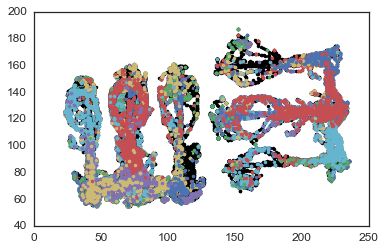

In [15]:
fig = plt.figure(1, figsize=(6, 4))
plt.axes(aspect=1)

for ep in ep_list:
    postimes = pos.query('Day==@dk & Epoch==@ep').time.item() # first match (should be only one)
    posx = pos.query('Day==@dk & Epoch==@ep').x.item() # first match (should be only one)
    posy = pos.query('Day==@dk & Epoch==@ep').y.item() # first match (should be only one)
    posvel = pos.query('Day==@dk & Epoch==@ep').vel.item() # first match (should be only one)
    plt.plot(posx[posvel > 3], posy[posvel > 3],'k.')
    for rowidx, spkitem in placecellspikes.query('Day==@dk & Epoch==@ep').iterrows() :
        spikeposidx = find_nearest(postimes, spkitem.spiketimes)
        #idx = np.searchsorted(postimes, all_spikes, side="left")
        #print(moving_idx.shape, idx.shape, posvel.shape)
        spikeposidx_moving = spikeposidx[posvel[spikeposidx] > 3]
        plt.plot(posx[spikeposidx_moving], posy[spikeposidx_moving],'.')



In [16]:

TetrodeList = list(set(tetinfo.query("Day==@dk & area=='CA1' & representative==1").Tetrode.tolist()))
print(TetrodeList)

eeg_data = [[frank_lab.load_data(fileroot, day=dk+1, epoch=ep+1, tetrode=t+1, version='new').data 
             for t in TetrodeList] for ep in ep_list]

FS = []
StartTime = []
TimeAxis = []
for ep in ep_list:
    eeg = frank_lab.load_data(fileroot, day=dk+1, epoch=ep+1, tetrode=TetrodeList[0]+1, version='new')
    FS.append(eeg.samprate)
    StartTime.append(eeg.starttime)
    TimeAxis.append(eeg.starttime + np.array(range(len(eeg.data))) / eeg.samprate)



[13]
Loading boneeg04-2-14.mat
Loading boneeg04-4-14.mat
Loading boneeg04-6-14.mat
Loading boneeg04-2-14.mat
Loading boneeg04-4-14.mat
Loading boneeg04-6-14.mat


In [17]:
# Maggie defines ripples by doing:
#  (1) filter 150-250
#  (2) hilbert envelope
#  (3) smooth with Gaussian (4 ms SD)
#  (4) 3.5SD above the mean for 15 ms
#  (5) full ripple defined as window back to mean

import ripples
SWR_bounds_idx = []
SmoothedRippleEnvelope = []
for epidx, ep in enumerate(ep_list): # loop over epochs
    SWR_bounds_idx.append([])
    for d in eeg_data[epidx]: # loop over electrodes
        rip_idx, ripple_maxes, ripple_inner_bounds, ripple_data, ripple_envelope, smoothed_envelope = \
            ripples.detect(d, FS=FS[epidx], ThresholdSigma=3.5, LengthCriteria=0.015)
        print(rip_idx.shape)
        SWR_bounds_idx[epidx].append(np.array(rip_idx))


(99, 2)
(124, 2)
(97, 2)


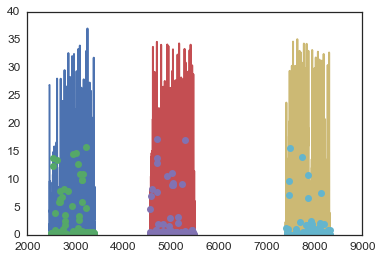

In [18]:
fig = plt.figure(1, figsize=(6, 4))

for idx,riplist in enumerate(SWR_bounds_idx):
    ep = ep_list[idx]
    postimes = pos.query('Day==@dk & Epoch==@ep').time.item() # first match (should be only one)
    posx = pos.query('Day==@dk & Epoch==@ep').x.item() # first match (should be only one)
    posy = pos.query('Day==@dk & Epoch==@ep').y.item() # first match (should be only one)
    posvel = pos.query('Day==@dk & Epoch==@ep').vel.item() # first match (should be only one)
    ripposidx = find_nearest(postimes, SWR_bounds_idx[idx][0][:,0]/FS[0] + StartTime[idx])
    plt.plot(postimes,posvel)
    plt.plot(postimes[ripposidx],posvel[ripposidx],'o')


In [19]:
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
#import klabtools as klab
#import seqtools as sq


In [20]:
from binning import bin_spikes
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)

all_spikes = []
bin_centers = []
for ep in ep_list:
    [bs, bb] = bin_spikes(
        [spkitem.spiketimes  for rowidx, spkitem in placecellspikes.query('Day==@dk & Epoch==@ep').iterrows()],
        ds=ds, fs = 1)
    all_spikes.append(bs)
    bin_centers.append(bb[:-1] + ds/2)




binning data into 7552.0 x 125.0 ms temporal bins...
binning data into 7495.0 x 125.0 ms temporal bins...
binning data into 7451.0 x 125.0 ms temporal bins...


In [21]:
# Next, find speeds for each bin
bin_vels = []
for epidx,ep in enumerate(ep_list):
    postimes = pos.query('Day==@dk & Epoch==@ep').time.item() # first match (should be only one)
    posvel = pos.query('Day==@dk & Epoch==@ep').vel.item() # first match (should be only one)
    binposidx = find_nearest(postimes, bin_centers[epidx])
    bin_vels.append(posvel[binposidx])

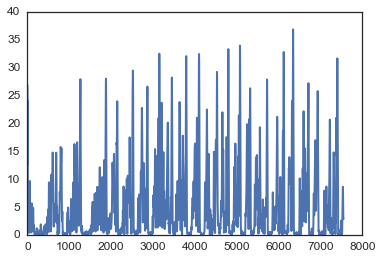

In [22]:
fig = plt.figure(1, figsize=(6, 4))
plt.plot(bin_vels[0])

In [23]:
# Extract sequences of spikes during which rat is moving faster than a threshold speed
speed_threshold = 3
moving_chunks = []
moving_bounds_idx = []
moving_bounds_t = []
for epidx,ep in enumerate(ep_list):
    moving_chunks.append([])
    moving_bounds_idx.append([])
    moving_bounds_t.append([])
    for s in np.ma.clump_masked(np.ma.masked_greater(bin_vels[epidx], speed_threshold)):
        moving_chunks[-1].append(all_spikes[epidx][s,:])
        moving_bounds_idx[-1].append([s.start, s.stop])
        moving_bounds_t[-1].append(bin_centers[epidx][0] + [ds * s.start, ds * s.stop])

    moving_bounds_idx[-1] = np.array(moving_bounds_idx[-1]) # convert list to np.array
    moving_bounds_t[-1] = np.array(moving_bounds_t[-1]) # convert list to np.array
        

In [24]:
from binning import windowed_bin_spikes
## bin SWR spikes into small bins for plotting
ds_swr = 0.005 # bin spikes into 10 ms bins somewhat standard
electrode = 0

swr_binned_spikes = []
swr_bin_centers = []
for epidx,ep in enumerate(ep_list):
    swr_bnds = SWR_bounds_idx[epidx][electrode]
    swr_bnds = StartTime[epidx] + swr_bnds/FS[epidx]
    swr_bnds[:,0] -= 0.05 # add 50 ms to start
    swr_bnds[:,1] += 0.1 # and 100 ms to end
    [bs, bb] = windowed_bin_spikes(
        [spkitem.spiketimes  for rowidx, spkitem in placecellspikes.query('Day==@dk & Epoch==@ep').iterrows()],
        swr_bnds, ds=ds_swr)
    swr_binned_spikes.append(bs)
    bc = [ev[:-1] + ds_swr/2 for ev in bb]
    bin_centers.append(bc)
    



/Users/ckemere/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ckemere/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ckemere/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ckemere/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ckemere/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ckemere/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


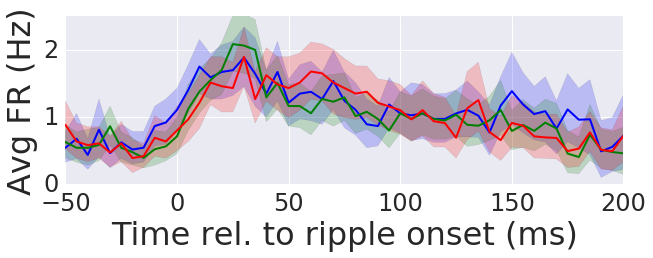

In [25]:
fig = plt.figure(1, figsize=(10, 3))
sns.set(rc={'lines.linewidth': 2, 'font.size': 24, 
            'axes.labelsize': 32, 'legend.fontsize': 18, 'ytick.labelsize': 24, 'xtick.labelsize': 24 })    

sns.set_style("darkgrid", {"font.sans-serif": "u'Bitstream Vera Sans'"})


cols = ['b','g','r']
for epidx in range(3):
    max_swr_bins = max([s.shape[0] for s in swr_binned_spikes[epidx]])
    total_firing = np.empty([len(swr_binned_spikes[epidx]), max_swr_bins])
    total_firing[:] = np.nan
    for i, s in enumerate(swr_binned_spikes[epidx]):
        total_firing[i,:s.shape[0]] = np.sum(s, axis=1)
    
    #plt.plot((ds_swr*np.arange(max_swr_bins) - 0.05)*1000, np.nanmean(total_firing, axis=0)/ds_swr/num_cells)
    sns.tsplot(data=total_firing/ds_swr/num_cells, 
               time=(ds_swr*np.arange(max_swr_bins) - 0.05)*1000, 
               estimator=np.nanmean,
               ci=95,
               color=cols[epidx])

ax = plt.gca()
ax.set_ylabel('Avg FR (Hz)')
ax.set_xlabel('Time rel. to ripple onset (ms)')
ax.set_xlim([-50, 200])
ax.set_ylim([0, 2.5])
ax.set_yticks([0, 1, 2])



In [ ]:
total_swr_spikes = [np.sum(s, for s in swr_binned_spikes[epidx]]




In [27]:
## bin SWR spikes
ds_swr = 0.01 # bin spikes into 10 ms bins somewhat standard
electrode = 0

swr_binned_spikes = []
swr_bin_centers = []
for epidx,ep in enumerate(ep_list):
    swr_bnds = SWR_bounds_idx[epidx][electrode]
    swr_bnds = StartTime[epidx] + swr_bnds/FS[epidx]
    [bs, bb] = windowed_bin_spikes(
        [spkitem.spiketimes  for rowidx, spkitem in placecellspikes.query('Day==@dk & Epoch==@ep').iterrows()],
        swr_bnds, ds=ds_swr)
    swr_binned_spikes.append(bs)
    bc = [ev[:-1] + ds_swr/2 for ev in bb]
    bin_centers.append(bc)

In [28]:
# For training, use the moving sequences
chunked_data = moving_chunks.copy()
chunked_bounds_idx = moving_bounds_idx.copy()
chunked_bounds_t = moving_bounds_t.copy()


In [29]:
import seqtools as sq

print(type(chunked_bounds_t[0]))
print(chunked_bounds_t[0].shape)

# Test model for novel track
mapdata = type('Map',(object,),dict(data=chunked_data[0], bin_width=ds, 
                                    boundaries=chunked_bounds_t[0], boundaries_fs=1))
## stack data for hmmlearn:
seq_stk_bvr = sq.data_stack(mapdata, verbose=True)

## split data into train, test, and validation sets:
tr_b,vl_b,ts_b = sq.data_split(seq_stk_bvr, tr=60, vl=20, ts=20, randomseed = 0, verbose=False)

<class 'numpy.ndarray'>
(130, 2)
130 sequences being stacked...
Total sequence length: 3744 bins, each of width 0.125 seconds
Successfully stacked 130 sequences for a total of 468.00 seconds of data.


In [30]:
Smax = 60
S = np.arange(start=5,step=5,stop=Smax+1)

tr_ll = []
vl_ll = []
ts_ll = []

for num_states in S:
    print('Training and evaluating {}-state hmm'.format(num_states))
    sys.stdout.flush()
    myhmm = sq.hmm_train(tr_b, num_states=num_states, n_iter=30, verbose=False)
    tr_ll.append( (np.array(list(sq.hmm_eval(myhmm, tr_b)))/tr_b.sequence_lengths ).mean())
    vl_ll.append( (np.array(list(sq.hmm_eval(myhmm, vl_b)))/vl_b.sequence_lengths ).mean())
    ts_ll.append( (np.array(list(sq.hmm_eval(myhmm, ts_b)))/ts_b.sequence_lengths ).mean())

print('Done!')


Training and evaluating 5-state hmm
Training and evaluating 10-state hmm
Training and evaluating 15-state hmm
Training and evaluating 20-state hmm
Training and evaluating 25-state hmm
Training and evaluating 30-state hmm
Training and evaluating 35-state hmm
Training and evaluating 40-state hmm
Training and evaluating 45-state hmm
Training and evaluating 50-state hmm
Training and evaluating 55-state hmm
Training and evaluating 60-state hmm
Done!


(5, 60)

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


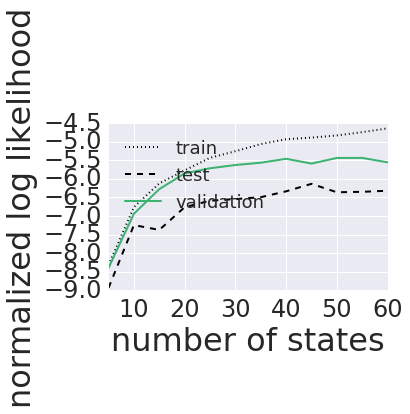

In [31]:

fig = plt.figure(1, figsize=(5, 3))
ax = fig.add_subplot(111)
    
ax.plot(S, tr_ll, lw=2, linestyle='dotted', label='train', color='k')
ax.plot(S, ts_ll, lw=2, linestyle='dashed', label='test', color='k')
ax.plot(S, vl_ll, lw=2, linestyle='solid', label='validation', color='mediumseagreen')
ax.legend(loc=2)
ax.set_xlabel('number of states')
ax.set_ylabel('normalized log likelihood')

ax.set_xlim([5, S[-1]])

In [32]:
# Check whether familiar model is good in the same size range

mapdata_fam = type('Map',(object,),dict(data=chunked_data[2], bin_width=ds, 
                                    boundaries=chunked_bounds_t[2], boundaries_fs=1))
## stack data for hmmlearn:
seq_stk_bvr_fam = sq.data_stack(mapdata_fam, verbose=True)

## split data into train, test, and validation sets:
tr_b_fam,vl_b_fam,ts_b_fam = sq.data_split(seq_stk_bvr, tr=60, vl=20, ts=20, randomseed = 0, verbose=False)


91 sequences being stacked...
Total sequence length: 3252 bins, each of width 0.125 seconds
Successfully stacked 91 sequences for a total of 406.50 seconds of data.


In [33]:
S = np.arange(start=5,step=5,stop=Smax+1)

tr_ll_fam = []
vl_ll_fam = []
ts_ll_fam = []

for num_states in S:
    print('Training and evaluating {}-state hmm'.format(num_states))
    sys.stdout.flush()
    myhmm_fam = sq.hmm_train(tr_b_fam, num_states=num_states, n_iter=30, verbose=False)
    tr_ll_fam.append( (np.array(list(sq.hmm_eval(myhmm_fam, tr_b_fam)))/tr_b_fam.sequence_lengths ).mean())
    vl_ll_fam.append( (np.array(list(sq.hmm_eval(myhmm_fam, vl_b_fam)))/vl_b_fam.sequence_lengths ).mean())
    ts_ll_fam.append( (np.array(list(sq.hmm_eval(myhmm_fam, ts_b_fam)))/ts_b_fam.sequence_lengths ).mean())

print('Done!')


Training and evaluating 5-state hmm
Training and evaluating 10-state hmm
Training and evaluating 15-state hmm
Training and evaluating 20-state hmm
Training and evaluating 25-state hmm
Training and evaluating 30-state hmm
Training and evaluating 35-state hmm
Training and evaluating 40-state hmm
Training and evaluating 45-state hmm
Training and evaluating 50-state hmm
Training and evaluating 55-state hmm
Training and evaluating 60-state hmm
Done!


(5, 60)

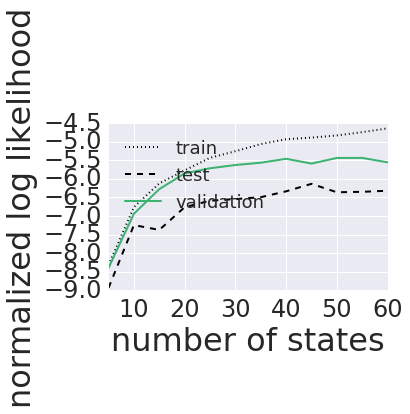

In [34]:

fig = plt.figure(1, figsize=(5, 3))
ax = fig.add_subplot(111)
    
ax.plot(S, tr_ll_fam, lw=2, linestyle='dotted', label='train', color='k')
ax.plot(S, ts_ll_fam, lw=2, linestyle='dashed', label='test', color='k')
ax.plot(S, vl_ll_fam, lw=2, linestyle='solid', label='validation', color='mediumseagreen')
ax.legend(loc=2)
ax.set_xlabel('number of states')
ax.set_ylabel('normalized log likelihood')

ax.set_xlim([5, S[-1]])

In [35]:
hmm = []
num_states = 30
stacked_data = []
for epidx, ep in enumerate(ep_list):
    mapdata = type('Map',(object,),dict(data=chunked_data[epidx], bin_width=ds, 
                                        boundaries=chunked_bounds_t[epidx], boundaries_fs=1))

    ## stack data for hmmlearn:
    stacked_data.append(sq.data_stack(mapdata, verbose=True))
    ## split data into train, test, and validation sets:
    tr,vl,ts = sq.data_split(stacked_data[-1], tr=60, vl=20, ts=20, randomseed = 0, verbose=False)
    hmm.append(sq.hmm_train(tr, num_states=num_states, n_iter=30, verbose=False))


130 sequences being stacked...
Total sequence length: 3744 bins, each of width 0.125 seconds
Successfully stacked 130 sequences for a total of 468.00 seconds of data.
120 sequences being stacked...
Total sequence length: 4161 bins, each of width 0.125 seconds
Successfully stacked 120 sequences for a total of 520.12 seconds of data.
91 sequences being stacked...
Total sequence length: 3252 bins, each of width 0.125 seconds
Successfully stacked 91 sequences for a total of 406.50 seconds of data.


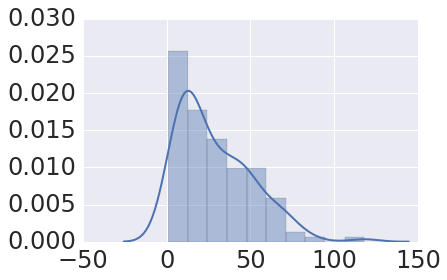

In [36]:
fig = plt.figure(1, figsize=(6, 4))
sns.distplot(stacked_data[0].sequence_lengths)

In [37]:
def get_replay_score_from_hmmlearn( hmmlearnModel, pth, obs ):
    # pth is a list of state indices, obs is a list (seq len) of lists (num cells) of nparray(rate)
    #P = np.exp(ymModel.dense_transition_matrix())
    logP = np.log(hmmlearnModel.transmat_)
    logPseq = 0
    logPctx = 0
    for ii in np.arange( 0, len(pth)-1 ):
        # add transition probability to sequence score:
        logPseq += logP[pth[ii],pth[ii+1]]
        # add memoryless observation likelihood to contextual score:
        logPctx += hmmlearnModel.score(obs[ii,:].reshape(1,-1)) # memoryless map probability per symbol FFFB! What about prior state probs?
        #logPctx += np.log(hmmlearnModel.predict_proba(obs[ii,:])[0][hmmlearnModel.decode(obs[ii,:])[1][0]]) # memoryless map probability per symbol FFFB! What about prior state probs?model.predict_proba(obs[ii-1,:])[0][model.decode(obs[ii-1,:])[1][0]]
        #print(logPctx)
    logPctx += hmmlearnModel.score(obs[-1,:].reshape(1,-1)) # memoryless map probability per symbol
    #logPctx += np.log(hmmlearnModel.predict_proba(obs[-1,:])[0][hmmlearnModel.decode(obs[-1,:])[1][0]]) # memoryless map probability per symbol FFFB! What about prior state probs?model.predict_proba(obs[ii-1,:])[0][model.decode(obs[ii-1,:])[1][0]]
    
    return logPseq/len(pth), logPctx/len(pth)

In [38]:
# compute sequence scores on all candidate events, and compare to trajectory shuffle:
from random import shuffle

scores = []
uniq_len = []
seq_len = []
for model_idx in range(len(ep_list)):
    scores.append([])
    uniq_len.append([])
    seq_len.append([])
    for ts_idx in range(len(ep_list)):
        data_to_test = stacked_data[ts_idx]

        myStackedDataSeq = data_to_test.data.copy()
        myStackedSeqLengths = data_to_test.sequence_lengths.copy()

        scores[model_idx].append({})
        scores[model_idx][ts_idx]['seq'] = np.zeros(len(myStackedSeqLengths))
        scores[model_idx][ts_idx]['ctx'] = np.zeros(len(myStackedSeqLengths))
        scores[model_idx][ts_idx]['shfl_seq'] = np.zeros(len(myStackedSeqLengths))
        scores[model_idx][ts_idx]['shfl_ctx'] = np.zeros(len(myStackedSeqLengths))

        uniq_len[model_idx].append([])

        seqlimits = np.cumsum(np.array([0] + list(myStackedSeqLengths)))
        #for ee in np.arange(0,len(myStackedSeqLengths)):
        for ee in range(len(chunked_data[ts_idx])):
            obs = chunked_data[ts_idx][ee]
            lp, pth = hmm[model_idx].decode(obs,algorithm='viterbi')
            
            #obs = myStackedDataSeq[seqlimits[ee]:seqlimits[ee+1],:]
            #lp, pth = hmm[model_idx].decode(obs,algorithm='viterbi')
            trj_shfl_idx = np.arange(0,len(pth))
            shuffle(trj_shfl_idx)
            pth_trj_shfl = [pth[i] for i in trj_shfl_idx]
            obs_trj_shfl = np.array([obs[i] for i in trj_shfl_idx])

            scores[model_idx][ts_idx]['seq'][ee], scores[model_idx][ts_idx]['ctx'][ee] = \
                get_replay_score_from_hmmlearn(hmm[model_idx], pth, obs)
            scores[model_idx][ts_idx]['shfl_seq'][ee], scores[model_idx][ts_idx]['shfl_ctx'][ee] = \
                get_replay_score_from_hmmlearn(hmm[model_idx], pth_trj_shfl, obs_trj_shfl)
            #print(ee)

            uniq_len[model_idx][ts_idx].append(len(set(pth))) # number of unique states visited in path

        seq_len[model_idx].append(myStackedSeqLengths) # sequence lengths

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


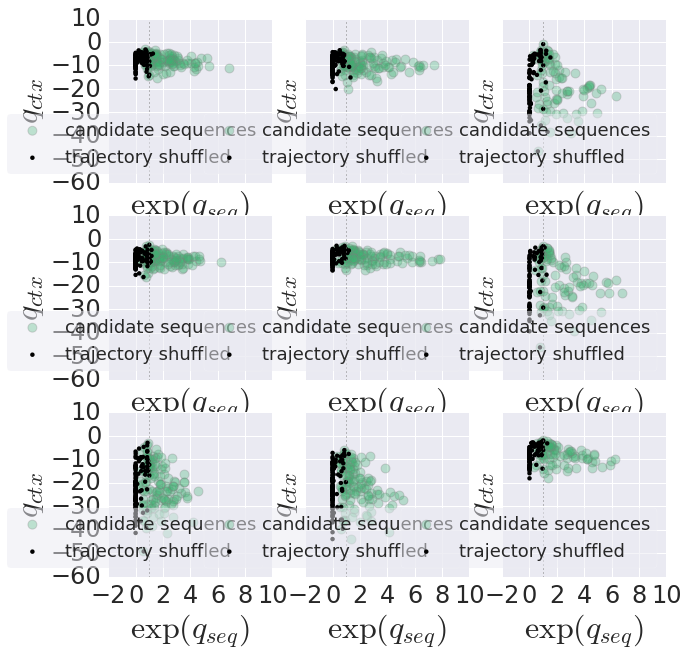

In [39]:

f, axs = plt.subplots(3,3, figsize=(10, 10), sharex=True, sharey=True)
for model_idx in range(len(ep_list)):
    for ts_idx in range(len(ep_list)):
        ax = axs[model_idx,ts_idx]
        ax.scatter(np.exp(scores[model_idx][ts_idx]['seq'])*np.array(uniq_len[model_idx][ts_idx]), 
                   scores[model_idx][ts_idx]['ctx'], 
                   s=80, c='mediumseagreen', alpha=0.3, marker='o',facecolors='none', 
                   edgecolors='gray',linewidth=1, label='candidate sequences')
        ax.scatter(np.exp(scores[model_idx][ts_idx]['shfl_seq'])*np.array(uniq_len[model_idx][ts_idx]), 
                   scores[model_idx][ts_idx]['shfl_ctx'], 
                   c='k', s=80, marker='.',facecolors='none', edgecolors='none',
                   linewidth=1, label='trajectory shuffled')
        ax.axvline(x=1, linewidth=1, color = 'gray', linestyle='dotted')
        ax.set_xlabel('$\exp(q_{seq})$')
        ax.set_ylabel('$q_{ctx}$')
        ax.legend(loc='lower right', fancybox=True, framealpha=0.5, frameon=True)

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


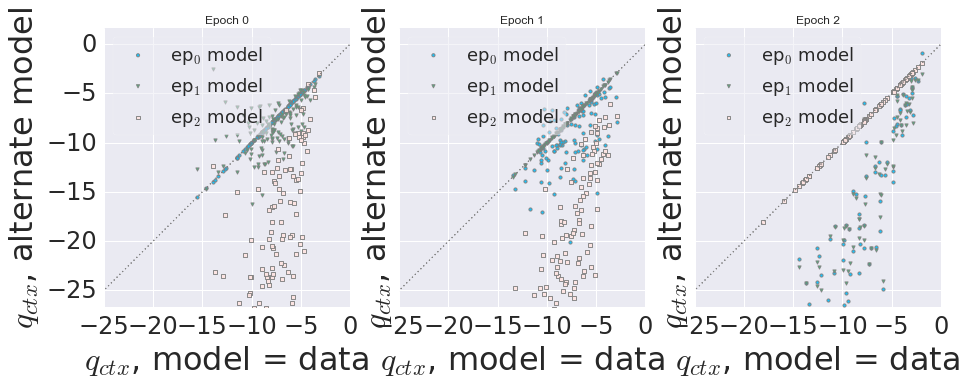

In [40]:
f, axs = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
cols = ['deepskyblue','mediumseagreen','mistyrose']
markers = ['o','v','s']
for ts_idx in range(len(ep_list)):
    ax = axs[ts_idx]
    for model_idx in range(len(ep_list)):
        ax.scatter(scores[ts_idx][ts_idx]['ctx'], 
                   scores[model_idx][ts_idx]['ctx'], 
                   s=10, c=cols[model_idx], alpha=0.9, marker=markers[model_idx],facecolors='none', 
                   edgecolors='gray',linewidth=1, label='ep$_{{{0}}}$ model'.format(model_idx))
        ax.plot([-60,0],[-60,0], linewidth=1, color = 'gray', linestyle='dotted')
        ax.legend(loc='upper left', fancybox=True, framealpha=0.5, frameon=True)
    ax.set_xlabel('$q_{ctx}$, model = data')
    ax.set_ylabel('$q_{ctx}$, alternate model')
    ax.set_title('Epoch {}'.format(ts_idx))
    ax.set_ylim([-25, 0])
    ax.set_xlim(ax.get_ylim())
    ax.set_aspect('equal', 'datalim')


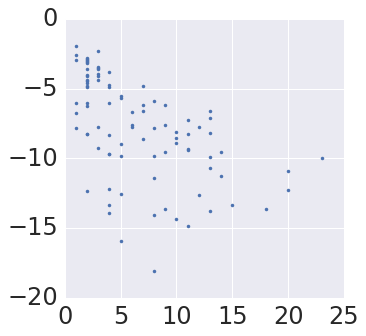

In [41]:
f, axs = plt.subplots(1, figsize=(5, 5), sharex=True, sharey=True)
axs.plot(uniq_len[model_idx][ts_idx], scores[model_idx][ts_idx]['ctx'],'.')

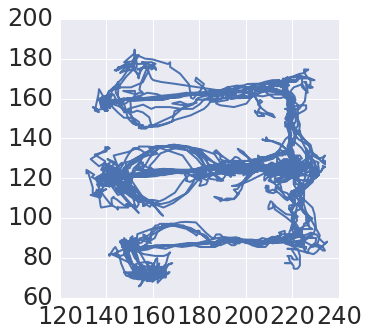

In [42]:
# Calculate state fields and place fields for a particular epoch

epidx = 2
ep = ep_list[epidx]

# Pull out position data for selected epoch 
postimes = pos.query('Day==@dk & Epoch==@ep').time.item() # first match (should be only one)
posvel = pos.query('Day==@dk & Epoch==@ep').vel.item() # first match (should be only one)
posx = pos.query('Day==@dk & Epoch==@ep').x.item() # first match (should be only one)
posy = pos.query('Day==@dk & Epoch==@ep').y.item() # first match (should be only one)

# get position on the same timescale as the observations
interpposx = np.interp(bin_centers[epidx], postimes, posx)
interpposy = np.interp(bin_centers[epidx], postimes, posy)

f, axs = plt.subplots(1, figsize=(5, 5))
plt.plot(interpposx,interpposy)


In [43]:
## 2D place field approximation
nbins = 40
xy00 = 0
xyLL = 250
bins = np.linspace(xy00, xyLL, nbins)

# Compute animal occupancy per spatial bin by adding up the number of time
#   bins he spends in each bin
hbins = np.linspace(xy00, xyLL, nbins+1) # histogram wants bin edges
H, _, _ = np.histogram2d(posx, posy, bins=hbins)
NormalizedOccupancy= H.copy()
NormalizedOccupancy[H==0] = np.nan

# Learn state / position mapping and place / position mapping by
#  iterating through each sequence and adding up all the state likelihoods/spikes
#  with the corresponding positions in each time bin

num_sequences = len(chunked_data[epidx])
num_states = hmm[epidx].n_components
place_fields = np.zeros((num_cells, nbins, nbins)) # stack of 2D place fields
state_pos2D = np.zeros((num_states, nbins, nbins)) # stack of 2D place fields

for seq_id in range(num_sequences):
    obs = chunked_data[epidx][seq_id]
    ll, pp = hmm[epidx].score_samples(obs)
    if num_sequences == 1:
        xx = interpposx
        yy = interpposy
    else:
        xx = interpposx[chunked_bounds_idx[epidx][seq_id][0]:chunked_bounds_idx[epidx][seq_id][1] +1]
        yy = interpposy[chunked_bounds_idx[epidx][seq_id][0]:chunked_bounds_idx[epidx][seq_id][1] +1]
    dxx = np.digitize(xx, bins) - 1 # spatial bin numbers
    dyy = np.digitize(yy, bins) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos2D[:,dxx[ii],dyy[ii]] += np.transpose(ppii)
        place_fields[:, dxx[ii], dyy[ii]] += np.transpose(obs[ii,:])

# place_fields[place_fields==0] = np.nan
# state_pos2D[state_pos2D==0] = np.nan

# normalize place fields
for ii, stateposfield in enumerate(state_pos2D):
        state_pos2D[ii,:,:] = stateposfield / NormalizedOccupancy
for ii, pf in enumerate(place_fields):
        place_fields[ii,:,:] = pf / NormalizedOccupancy


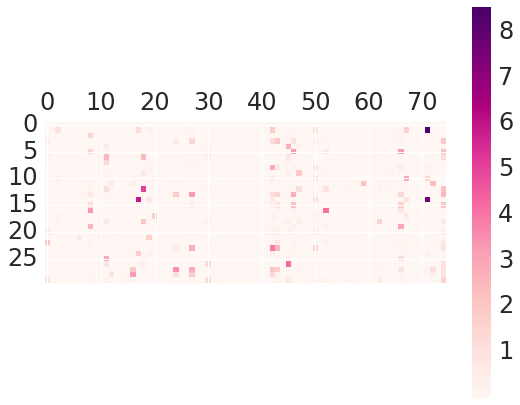

In [44]:
# Aside - plot observation matrix for model
fig = plt.figure(1, figsize=(9, 7))
ax = fig.add_subplot(111)
im = ax.matshow(hmm[epidx].means_,interpolation='none', cmap='RdPu',  )
fig.colorbar(im)



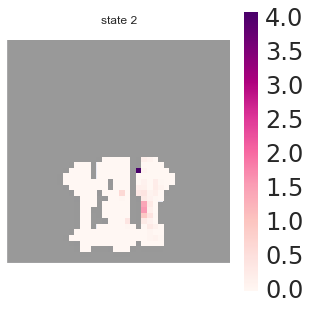

In [45]:
# Want to blank out space where the rat never goes
SpaceOverlay = H.copy() # Opposite of NormalizedOccupancy
SpaceOverlay[H>0] = np.nan 

import matplotlib.colors as pltcolors
NiceBG = pltcolors.ListedColormap(['0.6'])

sns.set_style('dark')
fig = plt.figure(1, figsize=(5, 5))
ax = fig.add_subplot(111)

state = 2
ax.matshow(SpaceOverlay,interpolation='none', cmap=NiceBG  )
# pf= ax.matshow(place_fields[state,::], cmap='RdPu')
pf = ax.matshow(state_pos2D[state,::], cmap='RdPu')
fig.colorbar(pf, ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('state ' + str(state))


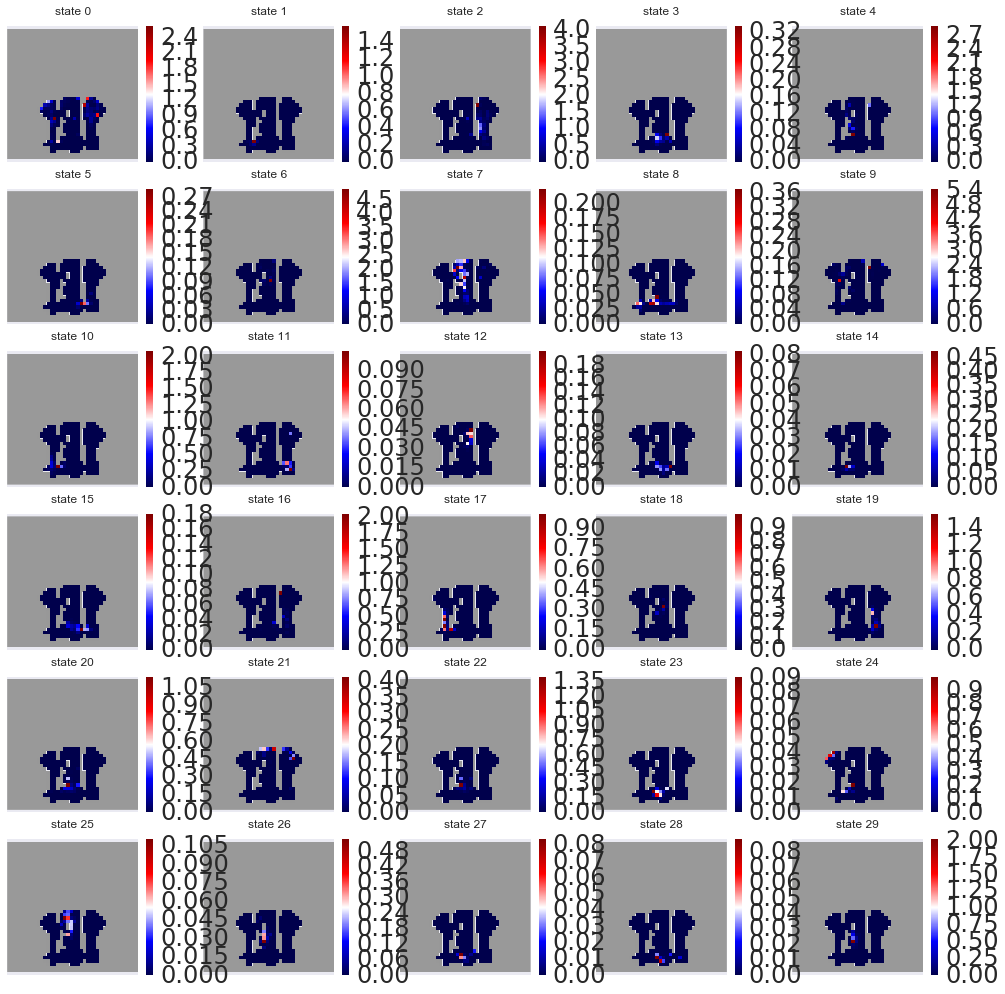

In [46]:
fig, axes = plt.subplots(6, 5, figsize=(17, 17), sharex=True, sharey=True)
axes = [item for sublist in axes for item in sublist]


#SpaceOverlay[H>0] = 1
for state, ax in enumerate(axes):
    ax.matshow(SpaceOverlay,interpolation='none', cmap=NiceBG  )
    # pf= ax.matshow(place_fields[state,::], cmap='RdPu')
    pf = ax.matshow(state_pos2D[state,::], cmap='seismic')
    fig.colorbar(pf, ax=ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('state ' + str(state))

In [47]:
len(swr_binned_spikes[0][0])

4

In [48]:
# compute sequence scores on all candidate swr events, and compare to trajectory shuffle:
from random import shuffle

swr_scores = []
swr_uniq_len = []
#swr_seq_len = []
for model_idx in range(len(ep_list)):
    swr_scores.append([])
    swr_uniq_len.append([])
    #swr_seq_len.append([])
    for ts_idx in range(len(ep_list)):
        swr_scores[model_idx].append({})
        swr_scores[model_idx][ts_idx]['seq'] = np.zeros(len(swr_binned_spikes[ts_idx]))
        swr_scores[model_idx][ts_idx]['ctx'] = np.zeros(len(swr_binned_spikes[ts_idx]))
        swr_scores[model_idx][ts_idx]['shfl_seq'] = np.zeros(len(swr_binned_spikes[ts_idx]))
        swr_scores[model_idx][ts_idx]['shfl_ctx'] = np.zeros(len(swr_binned_spikes[ts_idx]))

        swr_uniq_len[model_idx].append([])

        for ee in range(len(swr_binned_spikes[ts_idx])):
            obs = swr_binned_spikes[ts_idx][ee]
            lp, pth = hmm[model_idx].decode(obs,algorithm='viterbi')
            
            trj_shfl_idx = np.arange(0,len(pth))
            shuffle(trj_shfl_idx)
            pth_trj_shfl = [pth[i] for i in trj_shfl_idx]
            obs_trj_shfl = np.array([obs[i] for i in trj_shfl_idx])

            swr_scores[model_idx][ts_idx]['seq'][ee], swr_scores[model_idx][ts_idx]['ctx'][ee] = \
                get_replay_score_from_hmmlearn(hmm[model_idx], pth, obs)
            swr_scores[model_idx][ts_idx]['shfl_seq'][ee], swr_scores[model_idx][ts_idx]['shfl_ctx'][ee] = \
                get_replay_score_from_hmmlearn(hmm[model_idx], pth_trj_shfl, obs_trj_shfl)

            swr_uniq_len[model_idx][ts_idx].append(len(set(pth))) # number of unique states visited in path

        # swr_seq_len[model_idx].append(np.array([len(s) for s in swr_binned_spikes[ts_idx]])) # sequence lengths

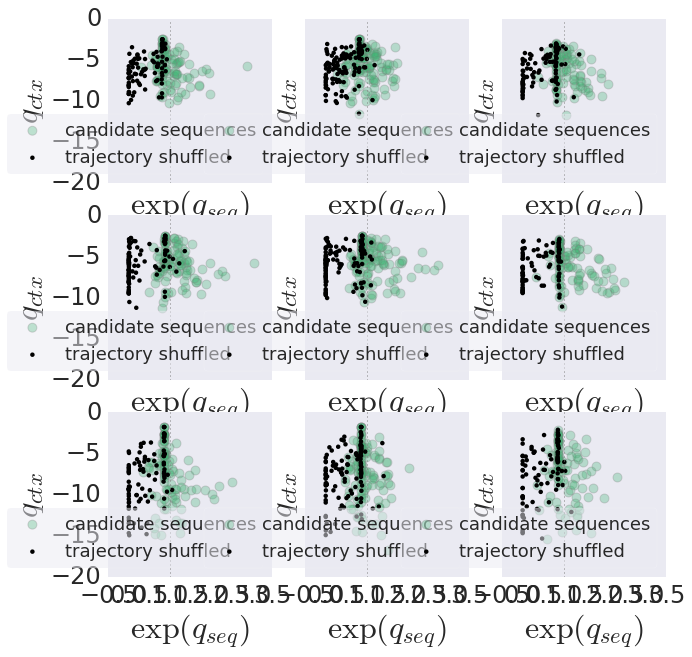

In [49]:

f, axs = plt.subplots(3,3, figsize=(10, 10), sharex=True, sharey=True)
for model_idx in range(len(ep_list)):
    for ts_idx in range(len(ep_list)):
        ax = axs[model_idx,ts_idx]
        ax.scatter(np.exp(swr_scores[model_idx][ts_idx]['seq'])*np.array(swr_uniq_len[model_idx][ts_idx]), 
                   swr_scores[model_idx][ts_idx]['ctx'], 
                   s=80, c='mediumseagreen', alpha=0.3, marker='o',facecolors='none', 
                   edgecolors='gray',linewidth=1, label='candidate sequences')
        ax.scatter(np.exp(swr_scores[model_idx][ts_idx]['shfl_seq'])*np.array(swr_uniq_len[model_idx][ts_idx]), 
                   swr_scores[model_idx][ts_idx]['shfl_ctx'], 
                   c='k', s=80, marker='.',facecolors='none', edgecolors='none',
                   linewidth=1, label='trajectory shuffled')
        ax.axvline(x=1, linewidth=1, color = 'gray', linestyle='dotted')
        ax.set_xlabel('$\exp(q_{seq})$')
        ax.set_ylabel('$q_{ctx}$')
        ax.legend(loc='lower right', fancybox=True, framealpha=0.5, frameon=True)

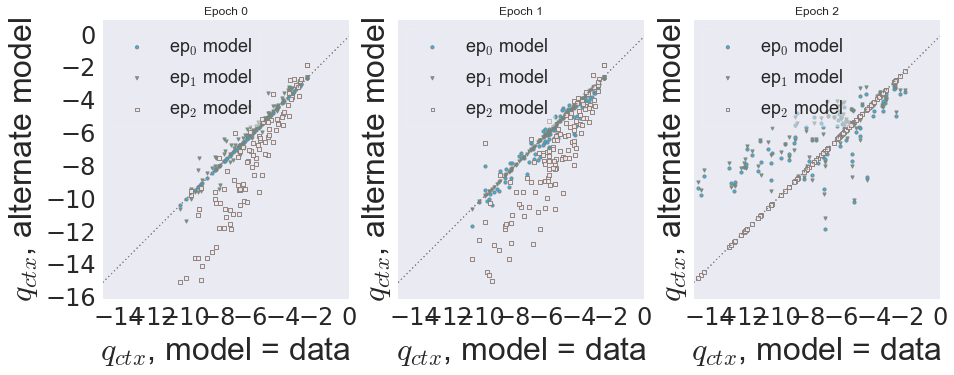

In [50]:
f, axs = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
cols = ['deepskyblue','mediumseagreen','mistyrose']
markers = ['o','v','s']
for ts_idx in range(len(ep_list)):
    ax = axs[ts_idx]
    for model_idx in range(len(ep_list)):
        ax.scatter(swr_scores[ts_idx][ts_idx]['ctx'], 
                   swr_scores[model_idx][ts_idx]['ctx'], 
                   s=10, c=cols[model_idx], alpha=0.9, marker=markers[model_idx],facecolors='none', 
                   edgecolors='gray',linewidth=1, label='ep$_{{{0}}}$ model'.format(model_idx))
        #ax.scatter(swr_scores[ts_idx][ts_idx]['shfl_ctx'], 
        #           swr_scores[model_idx][ts_idx]['shfl_ctx'], 
        #           c='k', s=80, marker='.',facecolors='none', edgecolors='none',
        #           linewidth=1, label='trajectory shuffled')
        ax.plot([-20,0],[-20,0], linewidth=1, color = 'gray', linestyle='dotted')
        #ax.axvline(x=1, linewidth=1, color = 'gray', linestyle='dotted')
        ax.legend(loc='upper left', fancybox=True, framealpha=0.5, frameon=True)
    ax.set_xlabel('$q_{ctx}$, model = data')
    ax.set_ylabel('$q_{ctx}$, alternate model')
    ax.set_title('Epoch {}'.format(ts_idx))
    ax.set_ylim([-15, 0])
    ax.set_xlim(ax.get_ylim())
    ax.set_aspect('equal', 'datalim')

